In [1]:
%matplotlib notebook
import math
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Sampling and integration in 1D
Here is a function I might like to integrate.

In [2]:
def f(x):
    return 1 - np.sqrt(1 - x**4)

<IPython.core.display.Javascript object>


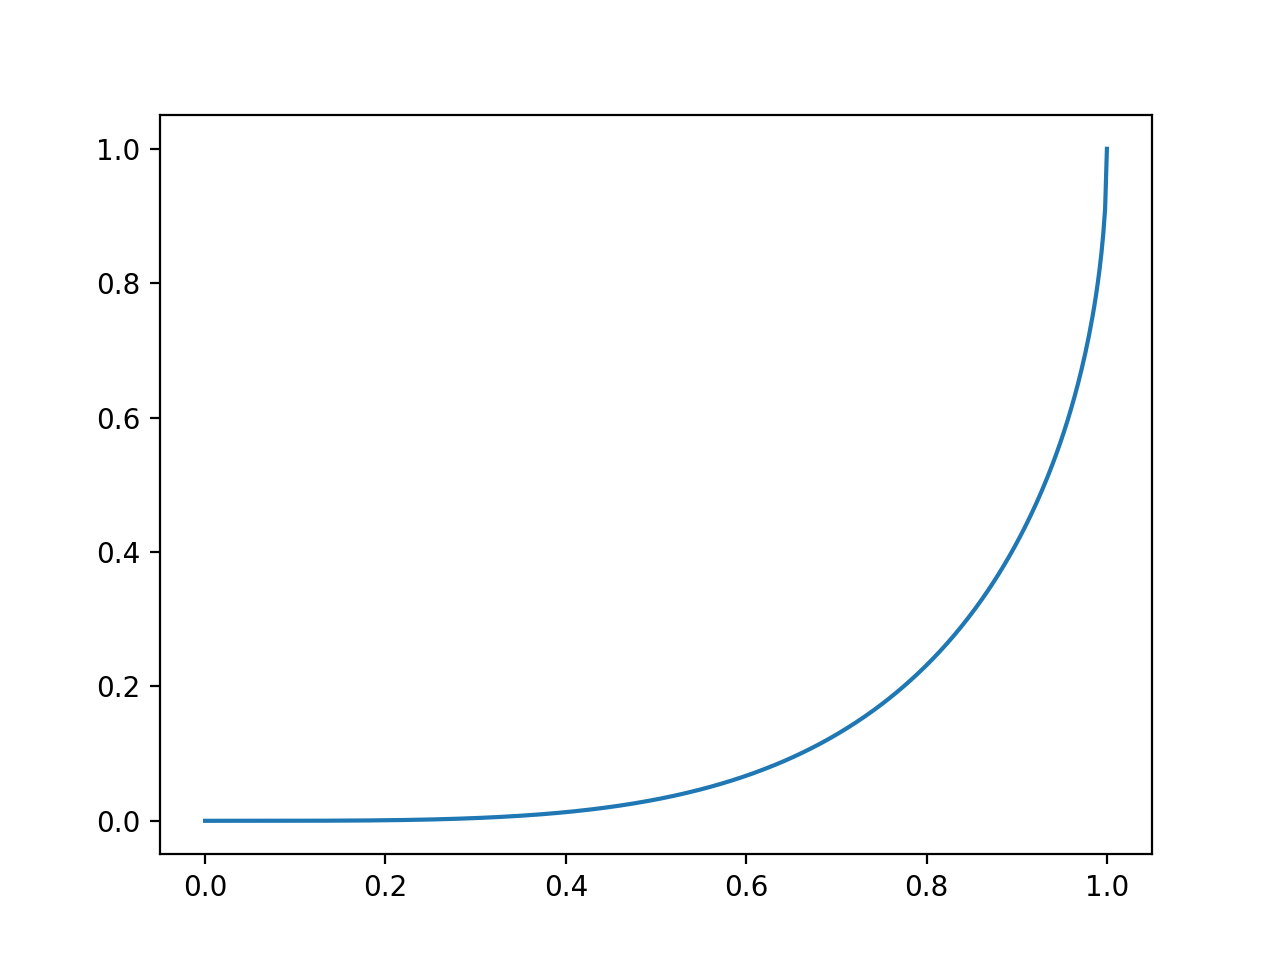

In [3]:
plt.figure()
xs = np.linspace(0, 1, 501)
plt.plot(xs, f(xs))

The integral of this function doesn't have a closed form.  Wolfram Alpha can integrate it in terms of the Elliptic Integral and gives the approximate value 0.125981 for the integral from 0 to 1.

The simplest Monte Carlo approach is to use uniform samples over the desired integration interval.

In [4]:
def estimate_simple(f, N):
    """Integrate f from 0 to 1 using N uniform random samples."""
    xs = np.random.random_sample(N)
    return np.mean(f(xs))

I can try this estimator with different numbers of samples to see how the accuracy improves:

In [24]:
estimate_simple(f, 100) - 0.125981

0.017430454614166729

I'm going to package this up in a "sampling strategy" that has the function, the code to generate samples, and the pdf of the samples, organized into a standard 3-method interface.

In [25]:
strategy1 = {
    'eval': lambda x: 1 - np.sqrt(1 - x**4),
    'sample': lambda xi: xi,
    'pdf': lambda x: np.ones(x.shape)
}

In [26]:
def estimate(strategy, N):
    """Integrate a function using N independent samples drawn from a provided pdf."""
    xis = np.random.random_sample(N)
    xs = strategy['sample'](xis)
    return np.mean(strategy['eval'](xs) / strategy['pdf'](xs))

I can do the same experiment as before using this interface.

In [28]:
estimate(strategy1, 100) - 0.125981

-0.0054208907947266571

Let's more scientifically compute the standard deviation of this estimator as a function of the number of samples.

In [29]:
def stdev_of(fn, M):
    """Compute the standard deviation of repeated calls to a function."""
    results = [fn() for i in range(M)]
    return np.std(results)

In [36]:
stdev_of(lambda: estimate(strategy1, 1000000), 100)

0.00018585707767197917

<IPython.core.display.Javascript object>


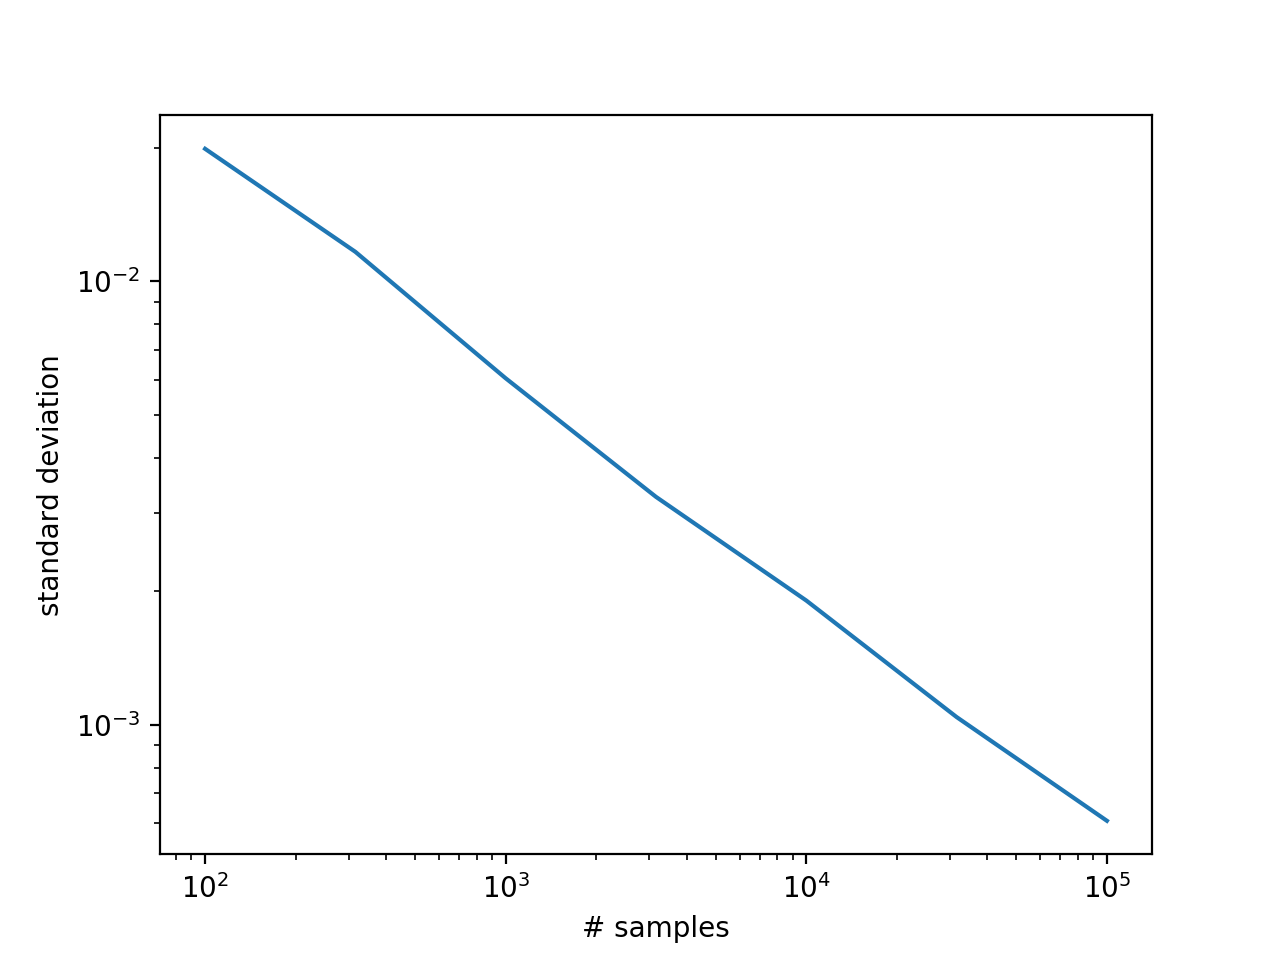

In [37]:
Ns = np.int32(np.logspace(2, 5, 7))
stdevs = [stdev_of(lambda: estimate(strategy1, N), 100) for N in Ns]
plt.figure()
plt.loglog(Ns, stdevs)
plt.xlabel('# samples')
plt.ylabel('standard deviation');

That shows a very clear trend: standard deviation is proportional to the square root of the number of samples.

$\sigma{G_n} = \sigma{g} N^{-1/2}$

$\log \sigma{G_n} = \log \sigma{g} - \frac{1}{2} \log N$

Here is another sampling stragegy, using the probability density $p(x) = 5 x^4$.

In [38]:
strategy2 = {
    'eval': lambda x: 1 - np.sqrt(1 - x**4),
    'sample': lambda xi: xi ** (1/5),
    'pdf': lambda x: 5 * x**4
}

The `sample` method is using the inverse-cdf algorithm.  The desired pdf is $p(x) = 5 x^4$; the corresponding cumulative distribution function (cdf) is 

$P(x) = \int_0^x 5t^4 dt = t^5$

and the inverse cdf is

$P^{-1}(\xi) = \xi^{1/5}$

First let's verify that this sampling method really generates the pdf that it claims to.  The following function computes many samples drawn from `sample` and plots a histogram showing the density of those samples against the value returned by the `pdf` method:

In [39]:
def histcheck(strategy, N):
    xis = np.random.random_sample(N)
    xs = strategy['sample'](xis)
    ps, edges, patches = plt.hist(xs, math.ceil(math.sqrt(N)/10), density=True)
    plt.plot(edges, strategy['pdf'](edges), 'k')

<IPython.core.display.Javascript object>


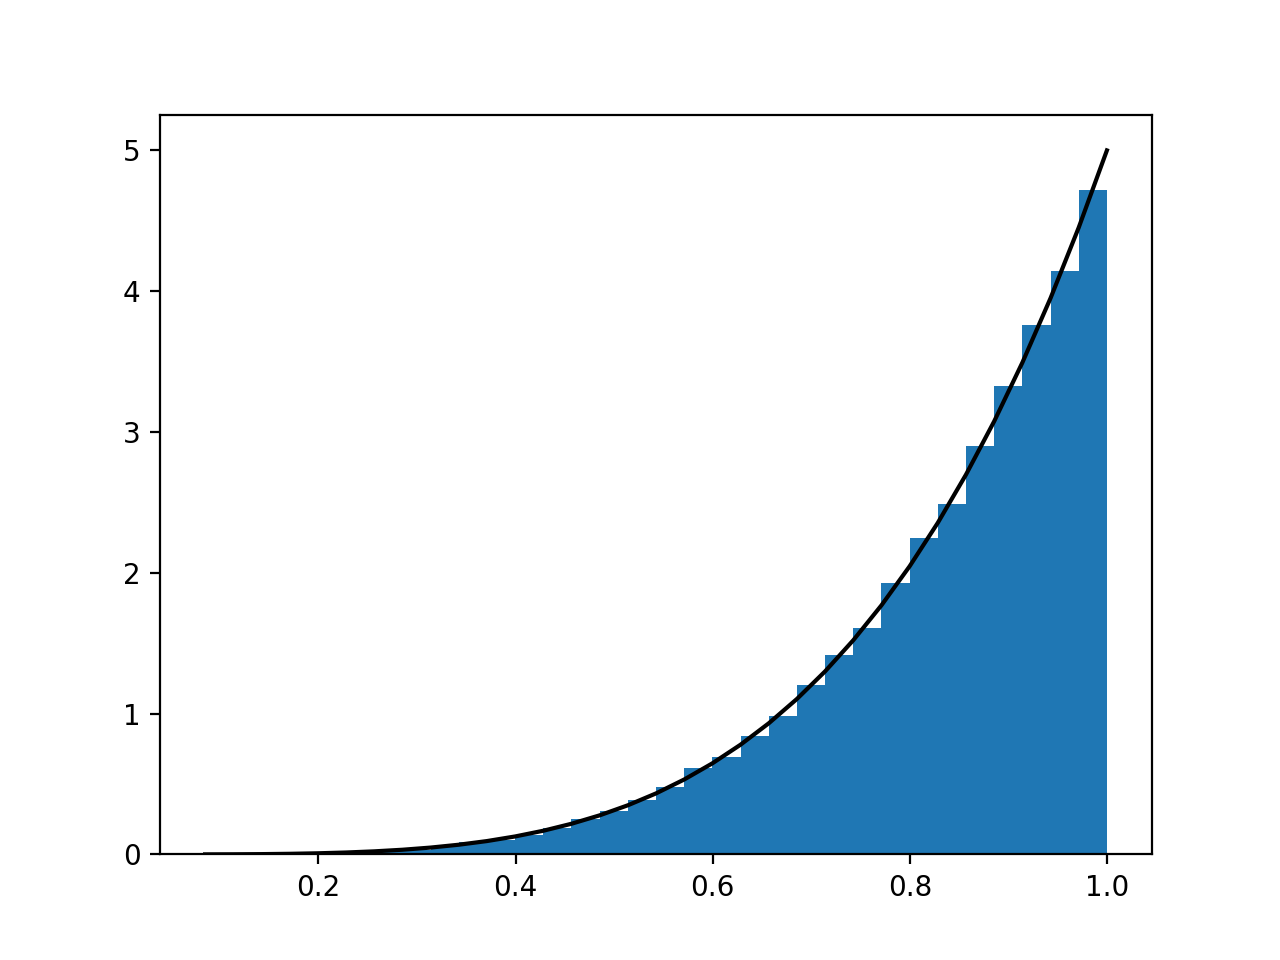

In [46]:
plt.figure()
histcheck(strategy2, 100000)

Good, that shows that the `pdf` method really does report the probability with which the `sample` method generates a sample near a given value.

In [42]:
estimate(strategy2, 100) - 0.125981

-0.0028189750121751789

In [48]:
stdev_of(lambda: estimate(strategy2, 1000), 100)

0.00070810434394445146

Now let's compare the standard deviation of this estimator to the other one, for various numbers of samples.

<IPython.core.display.Javascript object>


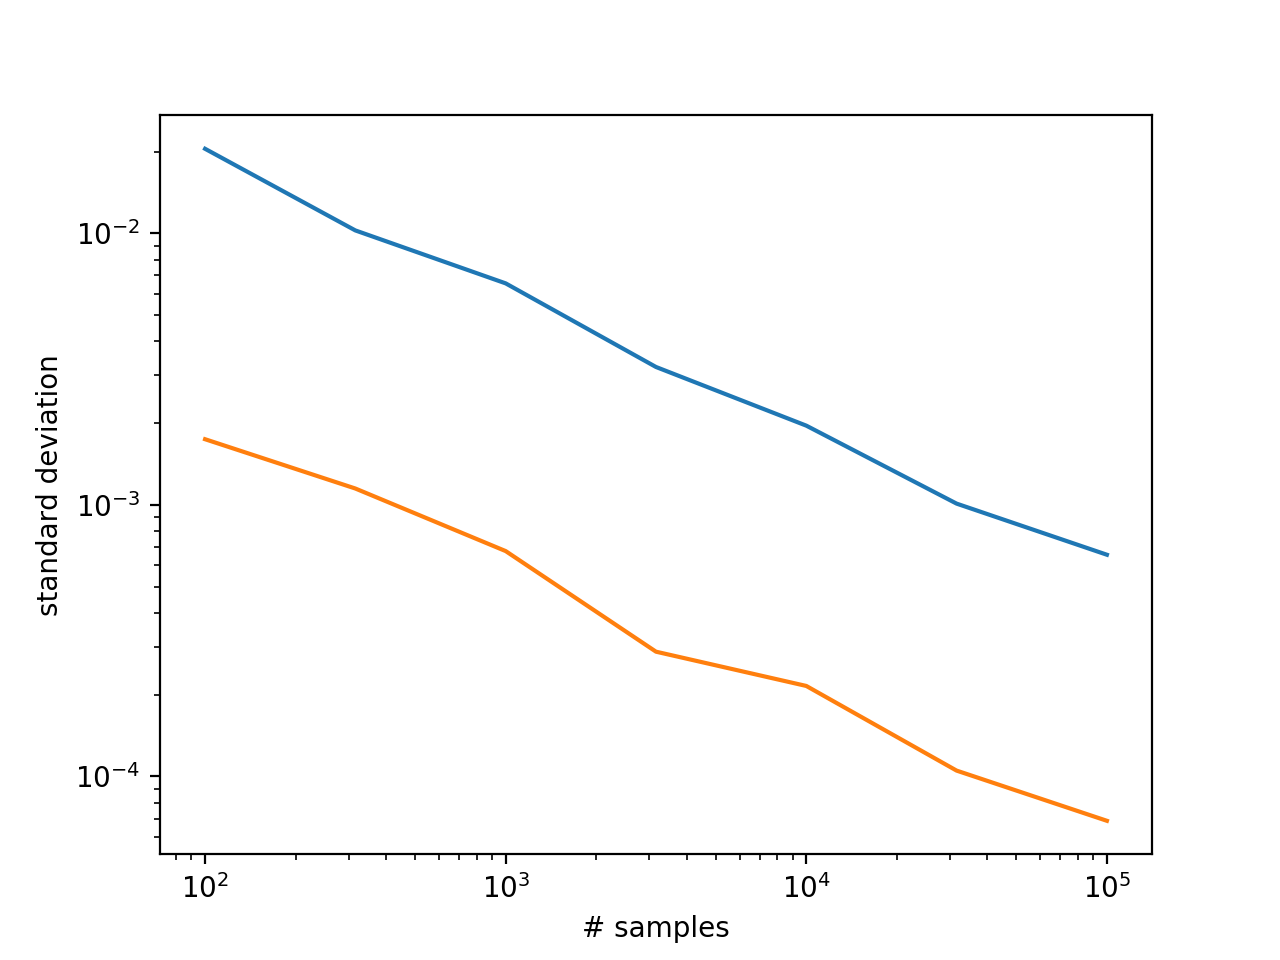

In [44]:
Ns = np.int32(np.logspace(2, 5, 7))
stdevs1 = [stdev_of(lambda: estimate(strategy1, N), 100) for N in Ns]
stdevs2 = [stdev_of(lambda: estimate(strategy2, N), 100) for N in Ns]
plt.figure()
plt.loglog(Ns, stdevs1, Ns, stdevs2)
plt.xlabel('# samples')
plt.ylabel('standard deviation');

This shows that second strategy outperforms the first one by a constant factor of about 10.

## Sampling uniformly from unit disc
To generate samples in the unit disc it is convenient to generate them in polar coordinate form.  Unfortunately uniformly generating $r$ and $\theta$ does not do it:

In [ ]:
def plot_circle(r, c='k'):
    plt.plot(r * np.cos(np.linspace(0,2*np.pi,121)), r * np.sin(np.linspace(0,2*np.pi,121)), c)

In [ ]:
rs = np.random.random_sample(10000)
thetas = 2 * np.pi * np.random.random_sample(10000)
plt.figure()
plt.plot(rs * np.cos(thetas), rs * np.sin(thetas), '.', ms=1)
plt.axis('equal')
plot_circle(1)

These samples are clumped towards the middle because the radii are uniformly distributed, so there are roughly equal numbers of points with $0 < r < 0.1$ and $0.9 < r < 1$.  But the areas on the plane corresponding to these two intervals in $r$ are very different.

In [ ]:
plot_circle(0.1)
plot_circle(0.9)

The area occupied by the interval between $r$ and $r+dr$ is proportional to $r$, so to generate points uniformly we want $p(r) \propto r$.  The integral of this is $\frac{1}{2}r^2$, so the normalized pdf is $p(r) = 2r$ with the cdf $P(r) = r^2$.  This means if we have a random number $\xi$ that's uniform on the unit interval, we can compute $r = \sqrt{\xi}$ and then $r \sim p(r)$.

In [ ]:
rs = np.sqrt(np.random.random_sample(10000))
plt.figure()
plt.plot(rs * np.cos(thetas), rs * np.sin(thetas), '.', ms=1)
plt.axis('equal')
plot_circle(1)

Hooray!  Now the points are uniformly distributed.
## Generating points on the unit hemisphere
In rendering, the random selections we are making are often directions, or point on the sphere, or hemisphere if we are talking about directions on one side of some surface.  The most basic distribution here is the uniform distribution.  How can we generate points that are uniformly distributed on the hemisphere?  As with the disc, uniformly choosing $\theta$ and $\phi$ is not going to work.

In [ ]:
def plot_hemisphere_points(xs, ys, zs):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_aspect('equal')
    plot_circle(1)
    ax.plot(xs, ys, zs, '.', ms=1)
    ax.set_xlim(-1,1)
    ax.set_ylim(-1,1)
    ax.set_zlim(0,2)

In [ ]:
thetas = np.pi/2 * np.random.random_sample(4000)
phis = 2 * np.pi * np.random.random_sample(4000)
xs = np.sin(thetas) * np.cos(phis)
ys = np.sin(thetas) * np.sin(phis)
zs = np.cos(thetas)
plot_hemisphere_points(xs, ys, zs)

The situation is quite similar, but the details are different: the surface area of a strip from $\theta$ to $\theta + d\theta$ is proportional to $\sin\theta$.  The cdf is $1 - \cos\theta$, so it is already normalized.  Thus we can use the transformation $\theta(\xi) = \cos^{-1}(1 - \xi)$ and we have $\theta \sim \sin\theta$.

In [ ]:
xis = np.random.random_sample(4000)
thetas = np.arccos(1 - xis)
phis = 2 * np.pi * np.random.random_sample(4000)
xs = np.sin(thetas) * np.cos(phis)
ys = np.sin(thetas) * np.sin(phis)
zs = np.cos(thetas)
plot_hemisphere_points(xs, ys, zs)

If you look at how we are computing the $z$ coordinate here, we are computing an arccosine followed by a cosine, which is a little silly.  We could instead just set $z = 1 - \xi$ and then compute $\sin\theta$ as $\sqrt{1 - z^2}$.

In [ ]:
xis = np.random.random_sample(4000)
zs = 1 - xis
phis = 2 * np.pi * np.random.random_sample(4000)
xs = np.sqrt(1 - zs**2) * np.cos(phis)
ys = np.sqrt(1 - zs**2) * np.sin(phis)
plot_hemisphere_points(xs, ys, zs)

One last very fundamental distribution on the hemisphere is the cosine distribution, in which we'd like the density on the hemisphere to be $p(\omega) = \cos\theta / \pi$.  (Here $\theta$ depends on $\omega$.)  The area of a $d\theta$ slice is still proportional to $\sin\theta$, so if the points are cosine distributed on the hemisphere we will find $p(\theta) \propto \cos\theta \sin\theta$.  Let's work this out out interactively.

Well, after struggling through some minus sign issues in class, we came to the conclusion that the proper cdf is $P(\theta) = \frac{1}{2}(1 - \cos 2\theta)$; solving, $\theta = \frac{1}{2} \cos^{-1}(1 - 2\xi)$.

In [ ]:
xis = np.random.random_sample(4000)
thetas = 1/2 * np.arccos(1 - 2*xis)
phis = 2 * np.pi * np.random.random_sample(4000)
xs = np.sin(thetas) * np.cos(phis)
ys = np.sin(thetas) * np.sin(phis)
zs = np.cos(thetas)
plot_hemisphere_points(xs, ys, zs)

An interesting feature of this point set is that if you project it down onto the unit disc (for instance, by viewing the plot from straight overhead), it looks uniform.  This is because an area $dA$ on the sphere projects to an area $dA \cos\theta$ on the equatorial plane, so the cosine-weighted distribution is the correct one.